### Data extraction
Extract data from MIMIC-III

In [1]:
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cufflinks

cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [2]:
# Import pandas 
import pandas as pd 

start = time.time()
# reading csv file 
admissions_df = pd.read_csv("../../datasets/mmc-3/ADMISSIONS.csv")
noteevents_df = pd.read_csv("../../datasets/mmc-3/NOTEEVENTS.csv") 
end = time.time()
print(end - start)


/home/evan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.



34.75624132156372


In [3]:
start = time.time()
# Left join of two dataframes
note_admiss_df_left = noteevents_df.merge(admissions_df, on='HADM_ID', how='left', indicator=True)
end = time.time()
print(end - start)

4.889202356338501


In [4]:
note_admiss_df_left[['DIAGNOSIS', 'SUBJECT_ID_x', 'SUBJECT_ID_y','DESCRIPTION', 'CATEGORY']]

,DIAGNOSIS,SUBJECT_ID_x,SUBJECT_ID_y,DESCRIPTION,CATEGORY
0,RT LOWER LOBE PNEUMONIA,22532,22532.0,Report,Discharge summary
1,CHRONIC OBSTRUCTIVE PULMONARY DISEASE,13702,13702.0,Report,Discharge summary
2,TRACHEALBRONCHEAL MALACEA/SDA,13702,13702.0,Report,Discharge summary
3,ASTHMA;COPD EXACERBATION,13702,13702.0,Report,Discharge summary
4,S/P FALL;TELEMETRY,26880,26880.0,Report,Discharge summary
...,...,...,...,...,...
2083175,NEWBORN,31097,31097.0,Report,Nursing/other
2083176,NEWBORN,31097,31097.0,Report,Nursing/other
2083177,NEWBORN,31097,31097.0,Report,Nursing/other
2083178,NEWBORN,31097,31097.0,Report,Nursing/other


In [5]:
pneumonia_df = note_admiss_df_left.loc[note_admiss_df_left["DIAGNOSIS"] == 'PNEUMONIA', ['ROW_ID_x', 'SUBJECT_ID_x', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'DIAGNOSIS', 'HAS_CHARTEVENTS_DATA']]

In [6]:
#pneumonia_no_disch_df = pneumonia_df.loc[pneumonia_df["CATEGORY"] != 'Discharge summary', ['ROW_ID_x', 'SUBJECT_ID_x', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'DIAGNOSIS', 'HAS_CHARTEVENTS_DATA']]
pneumonia_no_disch_df = pneumonia_df.loc[pneumonia_df["CATEGORY"] != 'Discharge summary', ['ROW_ID_x','SUBJECT_ID_x','CHARTDATE','STORETIME','CATEGORY','DESCRIPTION','TEXT', 'DEATHTIME']]

In [7]:
pneumonia_alive_no_disch = pneumonia_no_disch_df[pneumonia_no_disch_df.DEATHTIME.isnull()]
pneumonia_dead_no_disch = pneumonia_no_disch_df[pneumonia_no_disch_df.DEATHTIME.notnull()]

In [8]:
pneumonia_dead_no_disch.shape

(11895, 8)

In [9]:
pneumonia_alive_no_disch.shape

(46134, 8)

In [10]:
pneumonia_alive_no_disch = pneumonia_alive_no_disch.sort_values(by=['SUBJECT_ID_x','CHARTDATE', 'ROW_ID_x'])
pneumonia_dead_no_disch = pneumonia_dead_no_disch.sort_values(by=['SUBJECT_ID_x','CHARTDATE', 'ROW_ID_x'])

In [11]:
# Number of patients
pneumonia_dead_no_disch['SUBJECT_ID_x'].nunique()

252

In [12]:
# Number of patients
pneumonia_alive_no_disch['SUBJECT_ID_x'].nunique()

1167

In [13]:
# import text handling tool
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from collections import Counter

import sys
import re
import csv
import os.path

# define constants
# RESULT_HEADER = "WORD, FREQUENCY\n"
MIN_SEQ_LEN = 4
USE_1_N_SEQ = 2


# words that do not have meaning (can be modified later)
USELESS_WORDS = ["a", "the", "he", "she", ",", ".", "?", "!", ":", ";", "+", "*", "**"\
                 "your", "you"]

# count up the frequency of every word in every disease file
stemmer = PorterStemmer()
# create set of words to ignore in text
stop_words = set(stopwords.words('english'))

for word in USELESS_WORDS:
    stop_words.add(word)

In [14]:

#----------
def count_notes_per_patient(disease_df):
    patient_id_to_num_notes = {}
    patient_id = -1
    note_counter = 0
            
    for index, row in tqdm(disease_df.iterrows(), total=disease_df.shape[0]):
        patient_id_check = int(row['SUBJECT_ID_x'])
                
        if not patient_id == patient_id_check:
            patient_id_to_num_notes[patient_id] = note_counter
            note_counter = 1
        else:
            note_counter += 1
                    
        patient_id = patient_id_check
                
    patient_id_to_num_notes[patient_id] = note_counter
    del patient_id_to_num_notes[-1]
    return patient_id_to_num_notes

patient_id_to_num_notes = {}
patient_id_to_num_notes['pneumonia_dead'] = count_notes_per_patient(pneumonia_dead_no_disch)
patient_id_to_num_notes['pneumonia_alive'] = count_notes_per_patient(pneumonia_alive_no_disch)

100%|██████████| 46134/46134 [00:04<00:00, 9691.44it/s] 


In [15]:
patient_id_to_num_notes

{'pneumonia_dead': {111: 12,
  346: 25,
  404: 3,
  546: 6,
  618: 16,
  705: 15,
  726: 48,
  1039: 55,
  1556: 37,
  1872: 3,
  1944: 56,
  2286: 69,
  2990: 166,
  3055: 29,
  3099: 13,
  3201: 8,
  3526: 7,
  3773: 6,
  3881: 20,
  4122: 51,
  4754: 101,
  4811: 21,
  5476: 1,
  5494: 22,
  5774: 104,
  5786: 152,
  5913: 1,
  6133: 68,
  6735: 13,
  6745: 13,
  6973: 36,
  6981: 8,
  7277: 66,
  7310: 8,
  7924: 9,
  7977: 9,
  9908: 11,
  9984: 15,
  10302: 100,
  10510: 86,
  10545: 10,
  10642: 10,
  11049: 14,
  11209: 9,
  11395: 41,
  12530: 24,
  12849: 50,
  13098: 46,
  13566: 23,
  14125: 9,
  14514: 96,
  14965: 25,
  15159: 15,
  15251: 11,
  15396: 17,
  15566: 37,
  15853: 45,
  16275: 17,
  16344: 27,
  16622: 51,
  16684: 29,
  17122: 16,
  17354: 5,
  17802: 64,
  17983: 65,
  18094: 23,
  18736: 35,
  18768: 46,
  18848: 205,
  18971: 26,
  19243: 25,
  19323: 6,
  19390: 21,
  19463: 20,
  19535: 59,
  19754: 13,
  19827: 22,
  19833: 58,
  19872: 10,
  20006: 8

In [16]:
print(len(patient_id_to_num_notes['pneumonia_dead']))
print(len(patient_id_to_num_notes['pneumonia_alive']))

252
1167


In [17]:
pneumonia_dead_no_disch.loc[pneumonia_dead_no_disch["SUBJECT_ID_x"] == 111, ['ROW_ID_x','SUBJECT_ID_x','DESCRIPTION','TEXT', 'DEATHTIME']]

,ROW_ID_x,SUBJECT_ID_x,DESCRIPTION,TEXT,DEATHTIME
70391,70124,111,Report,PATIENT/TEST INFORMATION:\nIndication: s/p PEA...,2144-07-01 14:55:00
142529,151749,111,Report,Compared to the previous tracing QRS voltage i...,2144-07-01 14:55:00
142097,151750,111,Report,"Normal sinus rhythm, rate 80. Biatrial abnorm...",2144-07-01 14:55:00
142303,151751,111,Report,Normal sinus rhythm. Q waves in leads V1-V2 c...,2144-07-01 14:55:00
380576,375732,111,Physician Resident Admission Note,Chief Complaint: respiratory distress\n HPI...,2144-07-01 14:55:00
380109,375744,111,ICU Event Note,Clinician: Nurse\n Pt admitted from the ED ...,2144-07-01 14:55:00
379907,375749,111,Physician Resident/Attending Admission Note - ...,Chief Complaint: respiratory distress\n HPI...,2144-07-01 14:55:00
379806,375753,111,Social Work Admission Note,Social Work Initial Note:\n Family Informati...,2144-07-01 14:55:00
379909,375760,111,ICU Event Note,TITLE:\n Clinician: Resident\n Patient ex...,2144-07-01 14:55:00
1066971,1079317,111,CHEST (PORTABLE AP),[**2144-7-1**] 2:43 AM\n CHEST (PORTABLE AP) ...,2144-07-01 14:55:00


In [18]:
def count_words_per_patient(disease_df, patient_id_to_num_notes):
    note_appearance_counter = {}
    number_of_patients = 0 # number of patients
    note_counter = 0

# -----------
    patient_id = -1
    word_set = set()
    note_event_counter = 0

    # Iterate through each note
    for index, row in tqdm(disease_df.iterrows(), total=disease_df.shape[0]):

        
        patient_id_check = int(row['SUBJECT_ID_x'])
    
        # if patient id has changed, end sequence and start new sequence
        if not patient_id == patient_id_check:
            number_of_patients += 1
            note_event_counter = 0
        
            for word in word_set:
                if word in note_appearance_counter:
                    note_appearance_counter[word] += 1
                else:
                    note_appearance_counter[word] = 1

        
            # reset word_set
            word_set = set()
        
        # update patient id
        patient_id = patient_id_check

            
        if patient_id_to_num_notes[patient_id_check] <= MIN_SEQ_LEN:
            continue
            
        if note_event_counter < patient_id_to_num_notes[patient_id] // USE_1_N_SEQ:
            note_event_counter += 1
            continue
                
        note_counter += 1
        note = re.sub(r'\[\*\*(.*?)\*\*\]|[_,\d\*:~=\.\-\+\\/]+', ' ', row['TEXT'])
        tokenized_note = word_tokenize(note)
        
        
        for word in tokenized_note:
            stemmed_word = stemmer.stem(word.lower())
            if not stemmed_word in stop_words:
                word_set.add(stemmed_word)
    
    print(str(note_counter) + " note events")
    print("finished counting frequent words for patients!")
#     return note_counter, note_appearance_counter
    return number_of_patients, note_appearance_counter

# variable dictionaries
number_of_notes = {}
note_appearance_counter = {}

number_of_notes['pneumonia_dead'], note_appearance_counter['pneumonia_dead'] = count_words_per_patient(pneumonia_dead_no_disch, patient_id_to_num_notes['pneumonia_dead'])
number_of_notes['pneumonia_alive'], note_appearance_counter['pneumonia_alive'] = count_words_per_patient(pneumonia_alive_no_disch, patient_id_to_num_notes['pneumonia_alive'])

  0%|          | 13/46134 [00:00<05:55, 129.59it/s]

5989 note events
finished counting frequent words for patients!


100%|██████████| 46134/46134 [02:44<00:00, 280.56it/s]

23172 note events
finished counting frequent words for patients!


In [19]:
number_of_notes

{'pneumonia_dead': 252, 'pneumonia_alive': 1167}

In [20]:
print(note_appearance_counter)

{'pneumonia_dead': {'nc': 62, 'ast': 48, 'growth': 28, 'lower': 166, 'death': 42, 'cmh': 51, 'ptt': 80, 'head': 114, 'meq': 92, 'recent': 129, 'last': 148, 'versu': 30, 'servic': 92, 'septic': 41, 'pleural': 176, 'serial': 23, 'x': 185, 'htn': 50, 'requir': 145, 'dextros': 11, 'lactat': 47, 'demonstr': 88, 'prepar': 21, 'dx': 29, 'appoint': 7, 'pm': 197, 'marri': 4, 'elder': 1, 'occup': 18, 'cardiac': 156, 'epinephrin': 9, 'pedal': 41, 'set': 141, 'hi': 121, 'arf': 34, 'ha': 212, 'st': 140, 'elig': 3, 'includ': 113, 'underli': 79, 'hyperinfl': 5, 'alcohol': 15, 'paralyt': 16, 'hemodynam': 111, 'edema': 182, 'nutrit': 85, 'central': 107, 'park': 4, 'consult': 99, 'retrocardiac': 50, 'code': 135, 'hematoma': 20, 'took': 27, 'hpi': 58, 'densiti': 45, '#': 211, 'rebound': 8, 'continu': 176, 'inr': 88, 'lead': 83, 'salmeterol': 1, 'commun': 88, 'member': 57, 'hypercapnia': 4, 'home': 99, 'sinu': 139, 'vap': 72, 'differenti': 70, 'heart': 157, 'renal': 107, 'dr': 150, 'arteri': 119, 'clergi'

In [21]:
# # get hyper-paramters n_fold and threshold from user input
n_fold = float(3)
threshold = float(0.01)

frequent_word_lists = {}
factor = {}

In [22]:
"""function description:
for each disease in note_appearance_counter
    1. checks whether a word in disease file is frequent(frequency standard as defined by factor, n_fold, and threshold)
    2. adds to frequent_word_list
"""

# def find_frequent_word(note_appearance_counter, frequent_word_lists, number_of_notes, factor, n_fold, threshold):

# calculate normalizing factor for each disease
note_sum = 0

# Count from two labels
for disease in number_of_notes:
    note_sum += float(number_of_notes[disease])
    
for disease in number_of_notes:
    factor[disease] = number_of_notes[disease] / note_sum

# determine frequent word for each disease file
for disease in note_appearance_counter:
    frequent_word_lists[disease] = []

    print(disease + " has " + str(len(note_appearance_counter[disease])) + " unique words!")

    for word in note_appearance_counter[disease]:
        
        freq_check = True
        for check_disease in note_appearance_counter:
            
            if not disease == check_disease:
                if word in note_appearance_counter[check_disease]:
                    if not (note_appearance_counter[disease][word] / note_appearance_counter[check_disease][word] / factor[disease] * factor[check_disease] > n_fold \
                        and note_appearance_counter[disease][word] > (number_of_notes[disease] * threshold)):

                        freq_check = False
                        break

                else:
                    if not (note_appearance_counter[disease][word] > n_fold and note_appearance_counter[disease][word] > (number_of_notes[disease] * threshold)):
                        freq_check = False
                        break
        if freq_check:
            frequent_word_lists[disease].append((word))
            # Create a tuple of word and its count
#             frequent_word_lists[disease].append((word, note_appearance_counter[disease][word]))

        

print("finished making frequent words list for " + disease)

pneumonia_dead has 11678 unique words!
pneumonia_alive has 22572 unique words!
finished making frequent words list for pneumonia_alive


In [23]:
print(note_sum)
print(factor)

# number of notes
# 58029.0
# {'pneumonia_dead': 0.2049837150390322, 'pneumonia_alive': 0.7950162849609678}

1419.0
{'pneumonia_dead': 0.17758985200845667, 'pneumonia_alive': 0.8224101479915433}


In [24]:
print(len(frequent_word_lists['pneumonia_dead']))
print(len(frequent_word_lists['pneumonia_alive']))


# n_fold = float(3) threshold = float(0.01)
# 454
# 329

# n_fold = float(2) threshold = float(0.01)
# 914
# 600

# n_fold = float(1) threshold = float(0.01)
# 3320
# 2196

454
329


In [25]:
print(frequent_word_lists)

{'pneumonia_dead': ['death', 'elig', 'paralyt', 'park', 'hypercapnia', 'clergi', 'funer', 'arrang', 'phenylephrin', 'cpr', 'unrespons', 'dic', 'recruit', 'pcv', 'refractori', 'bicarbon', 'anur', 'expir', 'clinician', 'hypothermia', 'norepinephrin', 'vasopressin', 'mottl', 'cremat', 'acidem', 'arrest', 'azotemia', 'suffer', 'profound', 'pea', 'hypercapn', 'autopeep', 'dnr', 'sluggish', 'pinpoint', 'lubric', 'nonpurpos', 'virtual', 'slough', 'gum', 'dk', 'dni', 'cmo', 'nacl', 'oder', 'float', 'wish', 'mso', 'levoph', 'clariti', 'respon', 'remin', 'dd', 'dead', 'grim', 'purpl', 'option', 'prognosi', 'bow', 'suport', 'pronounc', 'peerla', 'hypotent', 'antb', 'institut', 'priest', 'gather', 'viabl', 'agreement', 'acv', 'mortem', 'aprv', 'mad', 'centimet', 'synch', 'depth', 'asystol', 'life', 'bye', 'duski', 'chaplain', 'hover', 'cathol', 'througout', 'moniotr', 'sync', 'mgx', 'ppn', 'nrbm', 'peac', 'surviv', 'cvvh', 'acidot', 'corneal', 'jerk', 'crrt', 'mortum', 'quiac', 'pfr', 'cvvhdf', 'a

### 2. Co-occurrence generation
FP-growth

In [26]:
FREQUENT_WORD_LIST = frequent_word_lists['pneumonia_dead'] + frequent_word_lists['pneumonia_alive']
print(len(FREQUENT_WORD_LIST))
print(len(set(FREQUENT_WORD_LIST)))

783
783


In [27]:
"""function description:
generates frequent word set for the disease
"""
word_dict = {}
word_id = 1
stemmer = PorterStemmer()


for word in FREQUENT_WORD_LIST:
    if not word == "WORD":
        word_dict[stemmer.stem(word.strip())] = word_id
        word_id += 1
             
print(f"\nword dictionary created! Length: {len(word_dict)}\n")
print(word_dict)



word dictionary created! Length: 783

{'death': 1, 'elig': 2, 'paralyt': 3, 'park': 4, 'hypercapnia': 5, 'clergi': 6, 'funer': 7, 'arrang': 8, 'phenylephrin': 9, 'cpr': 10, 'unrespon': 11, 'dic': 12, 'recruit': 13, 'pcv': 14, 'refractori': 15, 'bicarbon': 16, 'anur': 17, 'expir': 18, 'clinician': 19, 'hypothermia': 20, 'norepinephrin': 21, 'vasopressin': 22, 'mottl': 23, 'cremat': 24, 'acidem': 25, 'arrest': 26, 'azotemia': 27, 'suffer': 28, 'profound': 29, 'pea': 30, 'hypercapn': 31, 'autopeep': 32, 'dnr': 33, 'sluggish': 34, 'pinpoint': 35, 'lubric': 36, 'nonpurpo': 37, 'virtual': 38, 'slough': 39, 'gum': 40, 'dk': 41, 'dni': 42, 'cmo': 43, 'nacl': 44, 'oder': 45, 'float': 46, 'wish': 47, 'mso': 48, 'levoph': 49, 'clariti': 50, 'respon': 51, 'remin': 52, 'dd': 53, 'dead': 54, 'grim': 55, 'purpl': 56, 'option': 57, 'prognosi': 58, 'bow': 59, 'suport': 60, 'pronounc': 61, 'peerla': 62, 'hypot': 63, 'antb': 64, 'institut': 65, 'priest': 66, 'gather': 67, 'viabl': 68, 'agreement': 69, '

### Implementetion with python for FP_growth

### Count co-occurrences per patient

In [28]:
import os
import operator
from pathlib import Path
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import math

# ----
def fp_growth_input_per_patient_python(disease_df, word_dict, min_support):
    
    # For dataframe
    patient_cooc_dict = {}
    patient_node_dict = {}
    patient_note_cnt = {}
    
    # --------------    
    patient_id = -1
    note_cnt = 0
    patient_note_list = []
    
    # read line in from file (each line is one note)
    for index, row in tqdm(disease_df.iterrows(), total=disease_df.shape[0]):
        
        # only regard certain type of notes
        patient_id_check = int(row['SUBJECT_ID_x'])
        note = re.sub(r'\[\*\*(.*?)\*\*\]|[_,\d\*:~=\.\-\+\\/]+', ' ', row['TEXT'])
        patient_word_set = set()
    
#         print(f"patient_id_check: {patient_id_check}, patient_id: {patient_id}")
        # if patient id has changed, end sequence and start new sequence
        if not patient_id == patient_id_check and not patient_id == -1:
            te = TransactionEncoder()
            te_ary = te.fit(patient_note_list).transform(patient_note_list)
            df = pd.DataFrame(te_ary, columns=te.columns_)
            df_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
            
            cooc_tmp = []
            cooc_minsup_tmp = []
            node_minsup_tmp = []
            cooc_node_idx_tmp = []
            
            for index, row in df_itemsets.iterrows():
                if len(row['itemsets']) == 1:
                    word = list(row['itemsets'])[0]
                    min_sup = row['support']

                    node_minsup_tmp.append(len(patient_note_list) * row['support'])
                    cooc_node_idx_tmp.append(word)
                    
                if len(row['itemsets']) == 2:
                    cooc_ = sorted(list(row['itemsets']))
                    cooc_tmp.append(cooc_)
                    cooc_minsup_tmp.append(len(patient_note_list) * row['support'])
            
            cooc_dict = {}

            for num, i in enumerate(cooc_tmp):
                if tuple(i) not in cooc_dict:
                    cooc_dict[tuple(i)] = cooc_minsup_tmp[num]

            # dictionary = dict(zip(keys, values))
            node_dict = {}
            for num, i in enumerate(cooc_node_idx_tmp):
                if i not in node_dict:
                    node_dict[i] = node_minsup_tmp[num]
                    
            # Update glob lists
            if patient_id not in patient_cooc_dict:
                patient_cooc_dict[patient_id] = cooc_dict
                patient_node_dict[patient_id] = node_dict
                patient_note_cnt[patient_id] = note_cnt
            else:
                print(f"patient_id: {patient_id} is already in the dictionary!")
            
            
            # Reset local lists
            patient_note_list = []
            note_cnt = 0
                    
        # update patient id
        patient_id = patient_id_check
        tokenized_note = word_tokenize(note)
        note_cnt += 1

        # loop through each word in note to count word belonging to each disease
        for word in tokenized_note:
            stemmed_word = stemmer.stem(word.lower())       
            if stemmed_word in word_dict:
                    patient_word_set.add(stemmed_word)

        templst = []
        for word in patient_word_set:
            templst.append(word)

        if templst:
            patient_note_list.append(templst)
    
    # Last patient info
    te = TransactionEncoder()
    te_ary = te.fit(patient_note_list).transform(patient_note_list)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    df_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
            
    cooc_tmp = []
    cooc_minsup_tmp = []
    #-----
    node_minsup_tmp = []
    cooc_node_idx_tmp = []
            
    for index, row in df_itemsets.iterrows():
        if len(row['itemsets']) == 1:
            word = list(row['itemsets'])[0]
            node_minsup_tmp.append(len(patient_note_list) * row['support'])
            cooc_node_idx_tmp.append(word)

        if len(row['itemsets']) == 2:
            cooc_ = sorted(list(row['itemsets']))
            cooc_tmp.append(cooc_)
            cooc_minsup_tmp.append(len(patient_note_list) * row['support'])
    
                    
    cooc_dict = {}

    for num, i in enumerate(cooc_tmp):
        if tuple(i) not in cooc_dict:
            cooc_dict[tuple(i)] = cooc_minsup_tmp[num]

    # dictionary = dict(zip(keys, values))
    node_dict = {}
    for num, i in enumerate(cooc_node_idx_tmp):
        if i not in node_dict:
            node_dict[i] = node_minsup_tmp[num]

    # Update glob lists
    if patient_id not in patient_cooc_dict:
        patient_cooc_dict[patient_id] = cooc_dict
        patient_node_dict[patient_id] = node_dict
        patient_note_cnt[patient_id] = note_cnt
    else:
        print(f"patient_id: {patient_id} is already in the dictionary!")

    return patient_node_dict, patient_cooc_dict, patient_note_cnt

patient_node_0, patient_cooc_0, patient_note_num_0 = fp_growth_input_per_patient_python(pneumonia_dead_no_disch, word_dict, 0.15)
patient_node_1, patient_cooc_1, patient_note_num_1 = fp_growth_input_per_patient_python(pneumonia_alive_no_disch, word_dict, 0.15)

100%|██████████| 46134/46134 [06:39<00:00, 115.36it/s]


In [29]:
print(patient_node_1)

{68: {'commod': 4.0, 'ambul': 4.0, 'gait': 2.0, 'chair': 2.0, 'oob': 2.0}, 85: {'lat': 1.0}, 94: {'lift': 11.0, 'dopamin': 11.0}, 165: {'habitu': 1.0}, 211: {'dopamin': 3.0, 'aox': 3.0, 'levoph': 3.0}, 224: {'lat': 1.0, 'rigor': 1.0, 'platelet': 1.0, 'commod': 1.0, 'awhil': 1.0, 'fax': 1.0, 'bank': 1.0, 'pleasant': 1.0, 'chair': 1.0}, 231: {}, 283: {'recruit': 10.0, 'criticar': 10.0}, 357: {'unasyn': 4.0, 'intent': 2.0, 'dz': 2.0, 'ctx': 2.0, 'moan': 4.0, 'distort': 2.0}, 368: {'pleasant': 3.0, 'dnr': 3.0, 'hhn': 3.0, 'oob': 6.0, 'ambul': 4.0}, 370: {'dnr': 2.0}, 384: {'bipolar': 9.0, 'wish': 4.0, 'dnr': 3.0, 'schizophrenia': 4.0}, 426: {'align': 1.0, 'mottl': 1.0, 'lat': 1.0, 'unenhanc': 1.0, 'mail': 1.0, 'bronchovascular': 1.0, 'pleasant': 1.0, 'arthrit': 1.0}, 509: {'oob': 3.0}, 514: {'lat': 1.0, 'schizophrenia': 1.0, 'nicotin': 1.0, 'lighthead': 1.0, 'burn': 1.0, 'pleasant': 2.0, 'commod': 2.0, 'ambul': 1.0, 'oob': 1.0}, 596: {'dnr': 4.0, 'dopamin': 3.0, 'dni': 4.0, 'chair': 2.0}, 

In [30]:
print(patient_cooc_1)

{68: {('ambul', 'commod'): 3.0, ('ambul', 'oob'): 2.0, ('commod', 'oob'): 2.0}, 85: {}, 94: {}, 165: {}, 211: {}, 224: {('platelet', 'rigor'): 1.0, ('commod', 'platelet'): 1.0, ('commod', 'rigor'): 1.0, ('bank', 'fax'): 1.0, ('chair', 'pleasant'): 1.0}, 231: {}, 283: {}, 357: {('intent', 'unasyn'): 2.0, ('dz', 'intent'): 2.0, ('dz', 'unasyn'): 2.0, ('ctx', 'unasyn'): 2.0}, 368: {}, 370: {}, 384: {('bipolar', 'wish'): 4.0}, 426: {('lat', 'mottl'): 1.0, ('mail', 'unenhanc'): 1.0, ('bronchovascular', 'mail'): 1.0, ('bronchovascular', 'unenhanc'): 1.0, ('arthrit', 'pleasant'): 1.0}, 509: {}, 514: {('nicotin', 'schizophrenia'): 1.0, ('lighthead', 'nicotin'): 1.0, ('lighthead', 'schizophrenia'): 1.0, ('burn', 'lighthead'): 1.0, ('burn', 'nicotin'): 1.0, ('burn', 'schizophrenia'): 1.0, ('commod', 'pleasant'): 2.0, ('ambul', 'commod'): 1.0, ('ambul', 'pleasant'): 1.0, ('commod', 'oob'): 1.0, ('oob', 'pleasant'): 1.0}, 596: {('dni', 'dnr'): 2.0}, 674: {('nimv', 'profound'): 1.0, ('rememb', 'xl'

In [31]:
patient_note_num_0

{111: 12,
 346: 25,
 404: 3,
 546: 6,
 618: 16,
 705: 15,
 726: 48,
 1039: 55,
 1556: 37,
 1872: 3,
 1944: 56,
 2286: 69,
 2990: 166,
 3055: 29,
 3099: 13,
 3201: 8,
 3526: 7,
 3773: 6,
 3881: 20,
 4122: 51,
 4754: 101,
 4811: 21,
 5476: 1,
 5494: 22,
 5774: 104,
 5786: 152,
 5913: 1,
 6133: 68,
 6735: 13,
 6745: 13,
 6973: 36,
 6981: 8,
 7277: 66,
 7310: 8,
 7924: 9,
 7977: 9,
 9908: 11,
 9984: 15,
 10302: 100,
 10510: 86,
 10545: 10,
 10642: 10,
 11049: 14,
 11209: 9,
 11395: 41,
 12530: 24,
 12849: 50,
 13098: 46,
 13566: 23,
 14125: 9,
 14514: 96,
 14965: 25,
 15159: 15,
 15251: 11,
 15396: 17,
 15566: 37,
 15853: 45,
 16275: 17,
 16344: 27,
 16622: 51,
 16684: 29,
 17122: 16,
 17354: 5,
 17802: 64,
 17983: 65,
 18094: 23,
 18736: 35,
 18768: 46,
 18848: 205,
 18971: 26,
 19243: 25,
 19323: 6,
 19390: 21,
 19463: 20,
 19535: 59,
 19754: 13,
 19827: 22,
 19833: 58,
 19872: 10,
 20006: 8,
 20023: 9,
 20190: 6,
 21046: 101,
 21094: 36,
 21427: 10,
 21502: 102,
 21580: 52,
 21676: 12,


#### Create set of patient co-occurrences from two groups

In [32]:
# Create a set of all unique co-occurrences from both group
patient_cooc_set = set()
patient_cooc_0_dict = {}
patient_cooc_1_dict = {}

for k, v in patient_cooc_0.items():
    for item in v:
        patient_cooc_set.add(item)
        if item not in patient_cooc_0_dict:
            patient_cooc_0_dict[item] = v[item]
        else:
            patient_cooc_0_dict[item] = patient_cooc_0_dict[item] + v[item]
            
    
for k, v in patient_cooc_1.items():
    for item in v:
        patient_cooc_set.add(item)
        if item not in patient_cooc_1_dict:
            patient_cooc_1_dict[item] = v[item]
        else:
            patient_cooc_1_dict[item] = patient_cooc_1_dict[item] + v[item]

In [33]:
print(len(patient_cooc_set))
print(len(patient_cooc_0_dict))
print(len(patient_cooc_1_dict))

6776
1989
5152


In [34]:
# count log-odds score

# reverse
# --------------- co-occurrences --------------->

        
# Get the set of coocurrencies from two groups
# Count log_odd_score

patient_cooc_odd_scores = {}
for set_item in patient_cooc_set:
    if set_item in patient_cooc_0_dict and set_item in patient_cooc_1_dict: 
        d_prob = patient_cooc_0_dict[set_item]/(patient_cooc_0_dict[set_item] + patient_cooc_1_dict[set_item])
        a_prob = patient_cooc_1_dict[set_item]/(patient_cooc_0_dict[set_item] + patient_cooc_1_dict[set_item])
        log_odd_score = math.log((a_prob + 0.001)/(d_prob+0.001))
        patient_cooc_odd_scores[set_item] = log_odd_score
    elif set_item in patient_cooc_0_dict:
        log_odd_score = math.log((0.001)/(1.001))
        patient_cooc_odd_scores[set_item] = log_odd_score
    elif set_item in patient_cooc_1_dict:
        log_odd_score = math.log((1.001)/(0.001))
        patient_cooc_odd_scores[set_item] = log_odd_score
# --------------- co-occurrences ---------------<

In [35]:
patient_cooc_odd_scores

{('ardsnet', 'oligur'): -6.90875477931522,
 ('oob', 'sundown'): 6.90875477931522,
 ('habitu', 'phasic'): 6.90875477931522,
 ('cmo', 'sacrament'): -6.90875477931522,
 ('cramp', 'fibrinogen'): 6.90875477931522,
 ('knowledg', 'pod'): 6.90875477931522,
 ('hypothermia', 'paperwork'): 1.3825560390092835,
 ('dni', 'prilosec'): 6.90875477931522,
 ('osa', 'unstabl'): 6.90875477931522,
 ('anaphylaxi', 'ctx'): 6.90875477931522,
 ('ba', 'subq'): 6.90875477931522,
 ('dnr', 'laminectomi'): 6.90875477931522,
 ('bipolar', 'seriou'): 6.90875477931522,
 ('asthma', 'xl'): 6.90875477931522,
 ('anaphylaxi', 'shorter'): 6.90875477931522,
 ('dobutamin', 'vasopressin'): -6.90875477931522,
 ('laminectomi', 'subq'): 6.90875477931522,
 ('historian', 'incent'): 6.90875477931522,
 ('pleasant', 'stair'): 6.90875477931522,
 ('quinolon', 'uri'): 6.90875477931522,
 ('nectar', 'thk'): 6.90875477931522,
 ('acetazolamid', 'fibrinogen'): 6.90875477931522,
 ('cloth', 'commod'): -6.90875477931522,
 ('mottl', 'pleasant'): 6.

### Train mode

#### Method 2. Each patient graph => [model training]

In [36]:
# Dictionaries to use
 # struct: {word: word2vec[128, numpy.array]}
patient_cooc_odd_scores # struct: {cooc_tuple: log_odds_score}
print()

In [37]:
patient_cooc_odd_scores 

{('ardsnet', 'oligur'): -6.90875477931522,
 ('oob', 'sundown'): 6.90875477931522,
 ('habitu', 'phasic'): 6.90875477931522,
 ('cmo', 'sacrament'): -6.90875477931522,
 ('cramp', 'fibrinogen'): 6.90875477931522,
 ('knowledg', 'pod'): 6.90875477931522,
 ('hypothermia', 'paperwork'): 1.3825560390092835,
 ('dni', 'prilosec'): 6.90875477931522,
 ('osa', 'unstabl'): 6.90875477931522,
 ('anaphylaxi', 'ctx'): 6.90875477931522,
 ('ba', 'subq'): 6.90875477931522,
 ('dnr', 'laminectomi'): 6.90875477931522,
 ('bipolar', 'seriou'): 6.90875477931522,
 ('asthma', 'xl'): 6.90875477931522,
 ('anaphylaxi', 'shorter'): 6.90875477931522,
 ('dobutamin', 'vasopressin'): -6.90875477931522,
 ('laminectomi', 'subq'): 6.90875477931522,
 ('historian', 'incent'): 6.90875477931522,
 ('pleasant', 'stair'): 6.90875477931522,
 ('quinolon', 'uri'): 6.90875477931522,
 ('nectar', 'thk'): 6.90875477931522,
 ('acetazolamid', 'fibrinogen'): 6.90875477931522,
 ('cloth', 'commod'): -6.90875477931522,
 ('mottl', 'pleasant'): 6.

In [38]:
# Data normalization
import numpy
def data_norm(cooc_odd_scores):

    def norm_arr(array):
        arr = numpy.array(list(array))
        start = 0
        end = 1
        width = end - start
        res = (arr - arr.min())/(arr.max() - arr.min()) * width + start
        return res.tolist()

    cooc_keys, cooc_values = zip(*cooc_odd_scores.items())
    new_cooc_odd_scores = dict(zip(cooc_keys, norm_arr(cooc_values)))

    return new_cooc_odd_scores

new_patient_cooc_odd_scores = data_norm(patient_cooc_odd_scores)

In [39]:
new_patient_cooc_odd_scores

{('ardsnet', 'oligur'): 0.0,
 ('oob', 'sundown'): 1.0,
 ('habitu', 'phasic'): 1.0,
 ('cmo', 'sacrament'): 0.0,
 ('cramp', 'fibrinogen'): 1.0,
 ('knowledg', 'pod'): 1.0,
 ('hypothermia', 'paperwork'): 0.6000582654307438,
 ('dni', 'prilosec'): 1.0,
 ('osa', 'unstabl'): 1.0,
 ('anaphylaxi', 'ctx'): 1.0,
 ('ba', 'subq'): 1.0,
 ('dnr', 'laminectomi'): 1.0,
 ('bipolar', 'seriou'): 1.0,
 ('asthma', 'xl'): 1.0,
 ('anaphylaxi', 'shorter'): 1.0,
 ('dobutamin', 'vasopressin'): 0.0,
 ('laminectomi', 'subq'): 1.0,
 ('historian', 'incent'): 1.0,
 ('pleasant', 'stair'): 1.0,
 ('quinolon', 'uri'): 1.0,
 ('nectar', 'thk'): 1.0,
 ('acetazolamid', 'fibrinogen'): 1.0,
 ('cloth', 'commod'): 0.0,
 ('mottl', 'pleasant'): 1.0,
 ('aox', 'friction'): 1.0,
 ('morbid', 'wish'): 1.0,
 ('ntnd', 'option'): 0.0,
 ('declar', 'dni'): 0.0,
 ('ardsnet', 'vasopressin'): 0.0,
 ('laminectomi', 'predict'): 1.0,
 ('puff', 'refractori'): 1.0,
 ('gait', 'sensat'): 1.0,
 ('ambien', 'muir'): 1.0,
 ('arrang', 'arrest'): 0.0,
 ('an

In [40]:
# patient_dead_cooc_df
print(patient_cooc_0)

{111: {('arrest', 'pea'): 5.0, ('cpr', 'pea'): 4.0, ('arrest', 'cpr'): 4.0, ('cpr', 'vasopressin'): 4.0, ('pea', 'vasopressin'): 4.0, ('arrest', 'vasopressin'): 4.0, ('pcv', 'vasopressin'): 2.0, ('cpr', 'pcv'): 2.0, ('pcv', 'pea'): 2.0, ('arrest', 'pcv'): 2.0, ('paralyt', 'pcv'): 2.0, ('paralyt', 'vasopressin'): 2.0, ('cpr', 'paralyt'): 2.0, ('paralyt', 'pea'): 2.0, ('arrest', 'paralyt'): 2.0, ('norepinephrin', 'paralyt'): 2.0, ('norepinephrin', 'pcv'): 2.0, ('norepinephrin', 'vasopressin'): 2.0, ('cpr', 'norepinephrin'): 2.0, ('norepinephrin', 'pea'): 2.0, ('arrest', 'norepinephrin'): 2.0, ('hypothermia', 'norepinephrin'): 2.0, ('hypothermia', 'paralyt'): 2.0, ('hypothermia', 'pcv'): 2.0, ('hypothermia', 'vasopressin'): 2.0, ('cpr', 'hypothermia'): 2.0, ('hypothermia', 'pea'): 2.0, ('arrest', 'hypothermia'): 2.0, ('hypercapnia', 'hypothermia'): 2.0, ('hypercapnia', 'norepinephrin'): 2.0, ('hypercapnia', 'paralyt'): 2.0, ('hypercapnia', 'pcv'): 2.0, ('hypercapnia', 'vasopressin'): 2.0,

In [41]:
print(patient_node_0)

{111: {'arrest': 6.0, 'pea': 5.0, 'cpr': 4.0, 'vasopressin': 4.0, 'pcv': 2.0, 'paralyt': 2.0, 'norepinephrin': 2.0, 'hypothermia': 2.0, 'hypercapnia': 2.0, 'dic': 2.0, 'phenylephrin': 2.0, 'bicarbon': 2.0, 'azotemia': 2.0, 'autopeep': 2.0, 'death': 3.0, 'clinician': 2.0, 'profound': 2.0, 'expir': 2.0}, 346: {'arrest': 4.0, 'sluggish': 6.0}, 404: {'paco': 1.0, 'death': 1.0}, 546: {'oder': 1.0, 'hurt': 1.0, 'historian': 1.0}, 618: {'video': 2.0}, 705: {'dnr': 5.0, 'dni': 2.0, 'cmo': 5.0, 'mso': 2.0}, 726: {'mso': 3.0, 'dnr': 3.0}, 1039: {'wish': 4.0}, 1556: {'mso': 13.0, 'dnr': 8.0, 'dni': 8.0}, 1872: {'pronounc': 1.0}, 1944: {'arrest': 4.0, 'cvvhd': 5.0}, 2286: {'cyanot': 17.0, 'vasopressin': 14.0, 'levoph': 8.0, 'dnr': 7.0, 'prognosi': 7.0, 'purpl': 10.0, 'mottl': 7.0, 'pitressin': 15.0, 'incis': 10.0, 'anur': 9.0, 'cvvh': 9.0, 'hugger': 7.0, 'bair': 7.0}, 2990: {'chair': 17.0, 'oob': 17.0, 'levoph': 31.0, 'anur': 24.0}, 3055: {'gc': 3.0, 'wish': 3.0, 'cmo': 4.0}, 3099: {'neo': 2.0, 'n

In [42]:
# Check if all nodes has embeddings
patient_node_set = set()
patient_node_0_dict = {}
patient_node_1_dict = {}
    
for k, v in patient_node_0.items():
    for item in v:
        patient_node_set.add(item)
        
        if item not in patient_node_0_dict:
            patient_node_0_dict[item] = v[item]
        else:
            patient_node_0_dict[item] = patient_node_0_dict[item] + v[item]
        
    
for k, v in patient_node_1.items():
    for item in v:
        patient_node_set.add(item)
        
        if item not in patient_node_1_dict:
            patient_node_1_dict[item] = v[item]
        else:
            patient_node_1_dict[item] = patient_node_1_dict[item] + v[item]
        


In [43]:
print(len(patient_node_set))
print(len(patient_node_0_dict))
print(len(patient_node_1_dict))

633
379
571


In [44]:
patient_node_odd_scores = {}

for set_item in patient_node_set:
    if set_item in patient_node_0_dict and set_item in patient_node_1_dict:
        d_prob = patient_node_0_dict[set_item]/(patient_node_0_dict[set_item] + patient_node_1_dict[set_item])
        a_prob = patient_node_1_dict[set_item]/(patient_node_0_dict[set_item] + patient_node_1_dict[set_item])
        log_odd_score = math.log((a_prob + 0.001)/(d_prob+0.001))
        patient_node_odd_scores[set_item] = log_odd_score
    elif set_item in patient_node_0_dict:
        log_odd_score = math.log((0.001)/(1.001))
        patient_node_odd_scores[set_item] = log_odd_score
    elif set_item in patient_node_1_dict:
        log_odd_score = math.log((1.001)/(0.001))
        patient_node_odd_scores[set_item] = log_odd_score

In [45]:
print(patient_node_odd_scores)

{'news': -6.90875477931522, 'od': 6.90875477931522, 'death': -0.6916505477038827, 'hurt': 2.2927445483990123, 'treatement': 6.90875477931522, 'unobtain': 1.095952712632351, 'muir': 6.90875477931522, 'ultrafiltr': 6.90875477931522, 'dnr': 0.8878077019401656, 'crowd': 2.0716061679700735, 'osa': 3.0298720743851866, 'town': 2.9256884298210646, 'mind': 6.90875477931522, 'natg': 0.1332640725070919, 'hugger': -0.9072953759720636, 'ctx': 4.020284968191801, 'bronchovascular': 1.9739225981769513, 'argatroban': -0.8013676005646301, 'dietari': 6.90875477931522, 'gastrojejunostomi': 1.4998139424623853, 'deploy': 1.604655121332035, 'db': 1.7755423620716917, 'pneumothorac': 0.4585825764835029, 'moan': 1.0548445068920116, 'moreov': 6.90875477931522, 'pericard': 6.90875477931522, 'oximetri': 6.90875477931522, 'sluggish': 0.5836985542843016, 'pyuria': -0.46903068451456725, 'bmx': 6.90875477931522, 'cvvh': -0.02545138452962548, 'arthrit': 6.90875477931522, 'perpher': 1.9390841839849136, 'paralyt': 0.2651

In [46]:
patient_square_node_data = pd.DataFrame({'node':list(patient_node_odd_scores.keys()), 'feature':list(patient_node_odd_scores.values())})
patient_square_node_data

,node,feature
0,news,-6.908755
1,od,6.908755
2,death,-0.691651
3,hurt,2.292745
4,treatement,6.908755
...,...,...
628,contractur,2.899512
629,hunger,-1.865483
630,eg,6.908755
631,autopeep,-6.908755


In [47]:
patient_square_node_id_data = patient_square_node_data.set_index("node")
patient_square_node_id_data['subject'] = ["positive" if r['feature'] > 0 else "negative" for i, r in patient_square_node_id_data.iterrows()]
patient_square_node_id_data

,feature,subject
node,,
news,-6.908755,negative
od,6.908755,positive
death,-0.691651,negative
hurt,2.292745,positive
treatement,6.908755,positive
...,...,...
contractur,2.899512,positive
hunger,-1.865483,negative
eg,6.908755,positive


In [48]:
patient_subjects = patient_square_node_id_data["subject"]
patient_subjects

node
news          negative
od            positive
death         negative
hurt          positive
treatement    positive
                ...   
contractur    positive
hunger        negative
eg            positive
autopeep      negative
retic         positive
Name: subject, Length: 633, dtype: object

In [49]:
patient_square_node_data_no_feature = patient_square_node_id_data.drop(columns=["feature","subject"])
patient_square_node_data_no_feature

""
node
news
od
death
hurt
treatement
...
contractur
hunger
eg


In [50]:
from sklearn.manifold import TSNE
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec

### Create a bi-directional df

In [51]:
# with edge weight
bidirect_source = []
bidirect_target = []
edge_weight = []

for item, val in new_patient_cooc_odd_scores.items():
    bidirect_source.extend([item[0], item[1]])
    bidirect_target.extend([item[1], item[0]])
    edge_weight.extend([val, val])
    
print(f"source: {len(bidirect_source)}, target: {len(bidirect_target)}")

weighted_patient_bidirect_square_edge_data = pd.DataFrame(
    {
        "source": bidirect_source,
        "target": bidirect_target,
        "weight": edge_weight,
    })
weighted_patient_bidirect_square_edge_data

source: 13552, target: 13552


,source,target,weight
0,ardsnet,oligur,0.0
1,oligur,ardsnet,0.0
2,oob,sundown,1.0
3,sundown,oob,1.0
4,habitu,phasic,1.0
...,...,...,...
13547,tracheomalacia,scar,1.0
13548,readmit,seroquel,1.0
13549,seroquel,readmit,1.0
13550,declin,money,1.0


In [52]:
# Weighted
G_weighted_patient_bidirect = StellarGraph(
    {"corner": patient_square_node_data_no_feature}, {"line": weighted_patient_bidirect_square_edge_data}
)
print(G_weighted_patient_bidirect.info())

StellarGraph: Undirected multigraph
 Nodes: 633, Edges: 13552

 Node types:
  corner: [633]
    Features: none
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [13552]
        Weights: range=[0, 1], mean=0.734681, std=0.426758
        Features: none


In [53]:
# Weighted
rw_weighted_patient_bidirect = BiasedRandomWalk(G_weighted_patient_bidirect)

In [54]:
# Weighted
weighted_walks_patient_bidirect = rw_weighted_patient_bidirect.run(
    nodes=G_weighted_patient_bidirect.nodes(),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
#     weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks_patient_bidirect)))

Number of random walks: 6330


In [55]:
print(weighted_walks_patient_bidirect[0])

['news', 'morgu', 'declin', 'doen', 'declin', 'levoph', 'death', 'ferrou', 'trazodon', 'bromid', 'opiat', 'deterior', 'asthma', 'sluggish', 'bipolar', 'osa', 'knowledg', 'pleasant', 'vagu', 'hilum', 'habitu', 'anaphylaxi', 'impli', 'anaphylaxi', 'ultrafiltr', 'cocain', 'ppd', 'ultrafiltr', 'clonidin', 'nifedipin', 'lat', 'qtc', 'retic', 'hilum', 'dni', 'nitroglycerin', 'cocain', 'anaphylaxi', 'norepinephrin', 'dic', 'ggt', 'ctx', 'levoph', 'cardiovert', 'pitressin', 'neosynephrin', 'neo', 'lotion', 'ctx', 'metoclopramid', 'osa', 'ipf', 'fu', 'ipf', 'dni', 'pericard', 'platelet', 'ration', 'platelet', 'ration', 'profound', 'gait', 'sweat', 'syncop', 'sweat', 'fatti', 'sweat', 'hsq', 'young', 'asthma', 'cash', 'xl', 'mellitu', 'profound', 'thiamin', 'habitu', 'cocain', 'levoph', 'uri', 'dni', 'iddm', 'lat', 'ppd', 'vagu', 'influenc', 'gabapentin', 'sweat', 'dni', 'dnr', 'fungemia', 'fibrinogen', 'acidot', 'platelet', 'commod', 'incent', 'robitussin', 'dni', 'lat', 'dz', 'abnl']


In [56]:
# Weighted
weighted_model_patient = Word2Vec(
    weighted_walks_patient_bidirect, size=128, window=5, min_count=0, sg=1, workers=4, iter=1
)

In [57]:
# Weighted
emb = weighted_model_patient.wv["cmo"]
emb

array([ 3.57202142e-02, -8.53736047e-03,  7.85924494e-02, -2.50445575e-01,
       -2.14620754e-01,  9.52819288e-02,  9.94194672e-02,  8.71900991e-02,
        5.56090362e-02,  3.06516856e-01, -1.00073695e-01,  3.88583302e-01,
       -1.88541990e-02, -7.51716197e-02,  8.01729634e-02, -9.03299972e-02,
       -5.85361943e-02, -3.13977599e-02, -9.91175100e-02,  6.51407018e-02,
        2.68568695e-01, -3.96300294e-02,  2.53958762e-01,  1.23335905e-01,
       -4.74533230e-01,  1.49200112e-01,  3.55773345e-02, -3.49043161e-01,
        2.36195046e-02,  1.60133570e-01, -1.88516870e-01, -1.36292772e-02,
        2.17825994e-02,  1.44287691e-01,  1.35808170e-01,  4.10367638e-01,
       -2.06842735e-01, -4.51475978e-02, -4.50129574e-03, -1.13101013e-03,
       -6.41504973e-02, -1.72416121e-01, -1.28408208e-01, -1.07585164e-02,
       -3.31019051e-02,  2.67259985e-01,  3.87493908e-01, -6.26284555e-02,
        6.28070384e-02,  4.90730666e-02,  6.24985620e-02,  3.07914108e-01,
       -7.64955580e-02, -

### Visualise Node Embeddings generated by weighted random walks

### Weighted edges

In [58]:
# Retrieve node embeddings and corresponding subjects
patient_weighted_node_ids = weighted_model_patient.wv.index2word  # list of node IDs
patient_weighted_node_embeddings = (
    weighted_model_patient.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
# the gensim ordering may not match the StellarGraph one, so rearrange
patient_node_targets = patient_subjects.loc[patient_weighted_node_ids].astype("category")

In [59]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
patient_weighted_node_embeddings_2d = tsne.fit_transform(patient_weighted_node_embeddings)

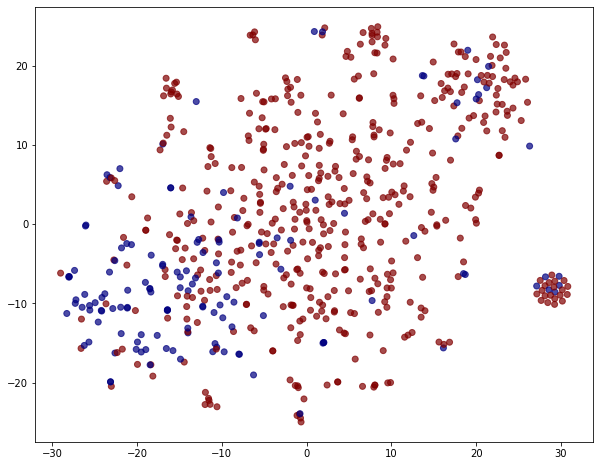

In [60]:
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    patient_weighted_node_embeddings_2d[:, 0],
    patient_weighted_node_embeddings_2d[:, 1],
    c=patient_node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()

In [61]:
patient_weighted_node_emb_dict = {}
for index, row in patient_square_node_data_no_feature.iterrows():
    if index not in patient_weighted_node_emb_dict:
        patient_weighted_node_emb_dict[index] = weighted_model_patient.wv[index]
    else:
        print(f"index: {index} is already in a dictionary!")

In [62]:
# print(type(patient_weighted_node_emb_dict['aprv']))

In [63]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

seed = 42
numpy.random.seed(seed)
tf.random.set_seed(seed)
sg.random.set_seed(seed)

### Load the data

In [64]:
from collections import defaultdict

def create_graph_list(patient_cooc_dict, cooc_odd_scores, node_emb_dict, label):
    
    graphs = []
    labels = []
    
    for key,row in patient_cooc_dict.items():
     
        if row:
            source = []
            target = []
            edge_weight = []
            
            node_feature = []
            node_idx = []
            for cooc in row:
                source.extend([cooc[0], cooc[1]])
                target.extend([cooc[1], cooc[0]])
                edge_weight.extend([cooc_odd_scores[cooc], cooc_odd_scores[cooc]])
        
            node_idx = list(set(source + target))
    
            # Create a dataframe of only nodes
            square_node_data = pd.DataFrame(
                index=node_idx)
            
#             square_node_data['feature'] = [1] * len(node_idx)
        
            # Create a dictionary for each column for a vector
            node_features = defaultdict(list)
            for node in node_idx:
                for i, vec in enumerate(node_emb_dict[node]):
                    node_features['w_' + str(i)].append(vec)
        
            # Add columns to a dataframe
            for k, v in node_features.items():
              
                square_node_data[k] = v

            square_edges = pd.DataFrame({ 
                "source": source, 
                "target": target, 
                "weight":edge_weight
            })
        
            square = StellarGraph({"corner": square_node_data}, {"line": square_edges})
            graphs.append(square)
            labels.append(label)
            
    return graphs, labels

graphs = []
labels = []

# patient_weighted_node_emb_dict
graph_0, label_0 = create_graph_list(patient_cooc_0, new_patient_cooc_odd_scores, patient_weighted_node_emb_dict, -1)
graph_1, label_1 = create_graph_list(patient_cooc_1, new_patient_cooc_odd_scores, patient_weighted_node_emb_dict, 1)

graphs.extend(graph_0)
labels.extend(label_0)
print(f"graphs_0: {len(graphs)}, labels_0: {len(labels)}")
graphs.extend(graph_1)
labels.extend(label_1)
print(f"graphs_1: {len(graph_1)}, labels_1: {len(label_1)}")
print(f"graphs: {len(graphs)}, labels: {len(labels)}")

graphs_0: 162, labels_0: 162
graphs_1: 726, labels_1: 726
graphs: 888, labels: 888


In [65]:
# prepare test and train datasets
test_cnt = int(len(graphs)*0.1)/2
print(test_cnt)

pos_start = len(graph_0)
print(pos_start)

test_arr = []
train_arr = []
for i, v in enumerate(graphs):
    # Take first items for neg set
    if i < test_cnt:
        test_arr.append(i)    
    elif i > pos_start and i <= pos_start + test_cnt:
        test_arr.append(i)    
    else:
        train_arr.append(i)

44.0
162


In [66]:
import random
seed = 42
c = list(test_arr)
random.Random(seed).shuffle(c)
test_arr =  c

In [67]:
c = list(train_arr)
random.Random(seed).shuffle(c)
train_arr =  c

In [68]:
train_index = np.array(train_arr)
test_index = np.array(test_arr)

In [69]:
print(len(test_index))
print(test_index)

88
[178 182  33  30  19  26 165 187  15 185  42   1 195 179 175  37 186  36
 171 164 192  20 202   8  41 198  40 177  32 174  39 205  43 196  12  23
  18 189 169 168   7  34 190   2  16  38 166  22 180  24   5   6 184 181
 199   9 206  21 191 163  10 170 167   0 203 176 201 172  25 193 183  29
  27 197 204   4 173 194  11 188  13  17  28  31  35   3  14 200]


78
[154 155 159   8 158 175  33  15 168 160 174 157 147 181 163  23  25   7
 167 164  36  18 172  19  20 149  30 169 165 173 150 170   2  16 166  22
 146  24   5   6 153 178   9 156  21 171 162  10   0 179  37 180 184  26
  34 151 148 152  12 182   1  38  32  29  27 177 183   4 161  11 176  13
  17  28  31  35   3  14]

In [70]:
print(len(train_index))
print(train_index)

800
[820 462 661 578 735 619 446 737 538 861 583 732 876 425  68 879 265 466
 428 149 486 132 703 509 288 289 577 319 327 464 108 822 818 317 632 700
 598 324 719 767 309 532 587 819 417 368 390 279 489 404 122 300 762 471
 824 479 744 838 389 238 626  80 690 273 260 268 136  53 445  94 551 118
 754  57 826 262 857 627 490 539 365 353 447 663 408 716 320 870 522 444
 791 595 301 728 777 335  52 442  72 835 734 485 582 611 413  54 675 473
 510 352 693 261 492 725 741 350 714 102 671 565 860  77 525  67 610 154
  61 286 775 695 569 678 665 250  86 814 351 236 670 812 638 789 519 568
 399 502 225 592 457 813 505 677 608 602 329  49 237 649 360 474 623 808
 207 497 128 684 755  60 590  83 325 394 469 381 615 226 783 129 666 766
 800 837 752 276 694 571 212 540 790 749 564 481 344 491 278  84 421 228
 463 217 272 337 511 281 844 240 697 403 452 739 315 866 705  75 378 480
 850 162 220 727 763  89 100 723 287 864 400 589 280 881 483 398 630 736
 339 664 573 883 531 555  93 235 545 560 150 51

709
[461 734 405 329 689 489 140 646 228 300  54 610 517 480  55 726  52 358
 113 432 502  67 664  78 417 653 576 603 287 258 464 341  44 705 125 544
 435 384 745 447 484 236 406 690 342 221 269 433 139  53 380 254 667 462
 309 250 418 715  63 634 725 626 665 252 661 299  41 144 470 437 574 635
 605 654 633 364 500  47 388 716 265 688 645 758  49 593 714  81 662 747
  75 343 193 290 514 278 291 563 333 350 545 655  72 604 459 475 368 494
 659 334 240 103 131 270 117 210 339 135  79 728 775 539 481 700 216 399
  97 276 102 477 196 722  95 641 438 419 227 505 518 704 778 263 145 340
 687 553 101 297 756 503 285 381 522 768  62 562 617 657 371  82 375 598
 631 398 456 197 404 706 386 315 515 413 731 255 394 218 268 116 601 579
 740 332 495 271 436 569 592 393 736 428 786 531 742 638 561 207 379 650
 695 615 781 751 482 527  56 188 541 530 249 266 458 262 402 625 469 490
 632 305 363 656 372 570 225 431 319 497 233 607 471 279 720 127 493 230
 560  48 429 226  84 389 559 478 759 346 513 215 293 552 344 208 242 776
 543 275 325 427 606 246 282 686 498 628 194 637 257 671 141 191 318 680
 273 549 723 214 640 616 390 130  51 289 129 122 521 407 533 566  91 538
 403 261 649 264 235 600 602 567 114 385 425  57 357 115 536 699 499 365
 296 360 535 121 212 105 248 613  61 672 504 524  65 618 707 336 528 453
 709 185 387 222 217 496 568  93 708 763 107  92 443 361 439 741 558 391
 232 356 673 501 223 267 203 474 256 446 582 337 532 353 440  90 366 396
 442  43  76 455 594 231 660 421 670 280 509 200 609 444 587 748 211 702
 345 367 376 414 713 476 395  59 473 534 204 369 100 554 198 423  73 382
  74 771  80 338 485 622 614 691 322 377 580 492 238 608 555 355 454 724
  68 189 229 546 118 327 744 591 719 761 452 434 647 685 310 508 620 213
 277  40 272 123 772 611 585 623 586 572 124 199 512 463  86 639 506 584
 411 784 581 783 677 550 573 304  77 525 739 314 588 729 565 727 307 767
 571 137 737  94 519 487 251 450 284  70  89 408 412 749 766 717 520 317
 288 612 259 750 415  88 668 136 286 491 577 479 202 320 373 370 529 556
 674 693 703 187 326 420 683 321 596 416 697 108 698  99 111  46 760 313
  60 424 663 308 331 201 540 526 762 678 397 283 692 511 684 247 564 209
 206 109 575 126 735 324  98 323 392 449 651  58 578 409  39 621 630 243
 460 666 764 642 383 186 597 260 590 679  42 718 239 523 733 785 753 712
 738 195  50 644 335 619 557 468 472 104 754 755 234 190  87 132 583 599
 219 710 730 486 675 516 676 347 629 765 330 780 349 224 547 483 589 295
 400 658 294 106 352 488 401 773 312  96 410 302 648 354 466 551 245 782
 624 253 701 112 351 292 441 457 244 451 542 752 746 142 769 120 374 311
  85 110 274 669 448 711 721 378 643 119 465 205 627 548  83 348 696 430
 445 138 467 133 779 422 298 237 757 426 774 241  45 362 681 537 303 507
 777 743 281 652  66 694 595 316 301 134  69  71 510 682 128 636 770 143
 220 306 328 359  64 192 732]

In [71]:
print(graphs[0].info())

StellarGraph: Undirected multigraph
 Nodes: 18, Edges: 212

 Node types:
  corner: [18]
    Features: float32 vector, length 128
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [212]
        Weights: range=[0, 0.788597], mean=0.0526238, std=0.175607
        Features: none


In [72]:
print(graphs[100].info())

StellarGraph: Undirected multigraph
 Nodes: 11, Edges: 76

 Node types:
  corner: [11]
    Features: float32 vector, length 128
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [76]
        Weights: range=[0, 0.552589], mean=0.214523, std=0.219258
        Features: none


In [73]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,888.0,888.0
mean,5.6,22.4
std,3.7,33.8
min,2.0,2.0
25%,2.0,2.0
50%,5.0,8.0
75%,8.0,26.0
max,23.0,272.0


In [74]:
graph_labels = pd.Series(labels)

In [75]:
print(graph_labels)

0     -1
1     -1
2     -1
3     -1
4     -1
      ..
883    1
884    1
885    1
886    1
887    1
Length: 888, dtype: int64


In [76]:
graph_labels.value_counts().to_frame()

,0
1,726
-1,162


In [77]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

In [78]:
print(type(graph_labels))

<class 'pandas.core.frame.DataFrame'>


In [79]:
graph_labels

,1
0,0
1,0
2,0
3,0
4,0
...,...
883,1
884,1
885,1
886,1


In [80]:
generator = PaddedGraphGenerator(graphs=graphs)

In [81]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

    return model

In [82]:
epochs = 200  # maximum number of training epochs
# folds = 10  # the number of folds for k-fold cross validation
# n_repeats = 5  # the number of repeats for repeated k-fold cross validation

In [83]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

In [84]:
# To train in folds
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [85]:
# To train in folds
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size, shuffle=False, seed=42
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size, shuffle=False, seed=42
    )

    return train_gen, test_gen

In [86]:
# # To train in folds
# test_accs = []

# stratified_folds = model_selection.RepeatedStratifiedKFold(
#     n_splits=folds, n_repeats=n_repeats
# ).split(graph_labels, graph_labels)

# for i, (train_index, test_index) in enumerate(stratified_folds):
#     print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
#     train_gen, test_gen = get_generators(
#         train_index, test_index, graph_labels, batch_size=30
#     )

#     model = create_graph_classification_model(generator)

#     history, acc = train_fold(model, train_gen, test_gen, es, epochs)

#     test_accs.append(acc)

In [87]:
# To train in folds
test_accs = []

# stratified_folds = model_selection.RepeatedStratifiedKFold(
#     n_splits=folds, n_repeats=n_repeats
# ).split(graph_labels, graph_labels)

# for i, (train_index, test_index) in enumerate(stratified_folds):
for i in range(50):
    print(f"Training and evaluating on fold {i+1}...")
    
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels, batch_size=30
    )

    model = create_graph_classification_model(generator)

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

Training and evaluating on fold 1...
Training and evaluating on fold 2...
Training and evaluating on fold 3...
Training and evaluating on fold 4...
Training and evaluating on fold 5...
Training and evaluating on fold 6...
Training and evaluating on fold 7...
Training and evaluating on fold 8...
Training and evaluating on fold 9...
Training and evaluating on fold 10...
Training and evaluating on fold 11...
Training and evaluating on fold 12...
Training and evaluating on fold 13...
Training and evaluating on fold 14...
Training and evaluating on fold 15...
Training and evaluating on fold 16...
Training and evaluating on fold 17...
Training and evaluating on fold 18...
Training and evaluating on fold 19...
Training and evaluating on fold 20...
Training and evaluating on fold 21...
Training and evaluating on fold 22...
Training and evaluating on fold 23...
Training and evaluating on fold 24...
Training and evaluating on fold 25...
Training and evaluating on fold 26...
Training and evaluati

In [88]:
# 1: Accuracy over all folds mean: 78.4% and std: 1.8%
# 2: Accuracy over all folds mean: 79.7% and std: 1.9%
# 3: Accuracy over all folds mean: 78.7% and std: 2.0%
# 4: Accuracy over all folds mean: 78.3% and std: 1.8%
# 5: Accuracy over all folds mean: 79.2% and std: 2.0%

# -----------------After setting random
# 1: Accuracy over all folds mean: 79.9% and std: 1.9%
# 2: Accuracy over all folds mean: 80.1% and std: 1.8%
# 3: Accuracy over all folds mean: 78.5% and std: 1.6%
# 4: Accuracy over all folds mean: 77.3% and std: 1.9%
# 5: Accuracy over all folds mean: 77.5% and std: 2.0%
# 6: Accuracy over all folds mean: 79.3% and std: 2.3%
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 79.7% and std: 2.4%


Text(0, 0.5, 'Count')

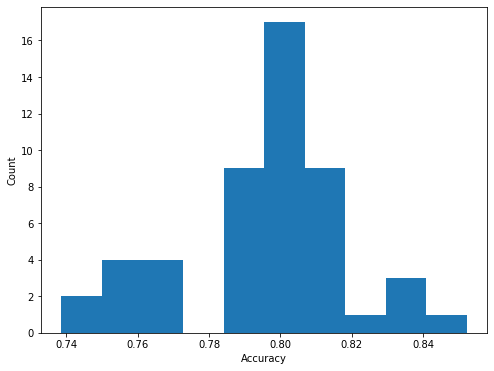

In [89]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

In [93]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 76.6% and std: 2.0%


Text(0, 0.5, 'Count')

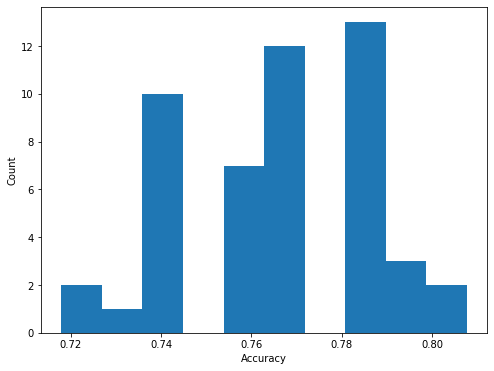

In [94]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

In [ ]:
# stratified_folds = model_selection.RepeatedStratifiedKFold(
#     n_splits=folds, n_repeats=n_repeats
# ).split(graph_labels, graph_labels)

# for i, (train_index, test_index) in enumerate(stratified_folds):
#     print(f"\ntrain_index: \n{train_index}\ntest_index: \n{test_index}\n")
#     break
# print(f"train: {len(train_index)}, test: {len(test_index)}")

In [84]:
train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=40, shuffle=False, seed=42)
test_gen = generator.flow(
    test_index, targets=graph_labels.iloc[test_index].values, batch_size=40, shuffle=False, seed=42)

In [85]:
model_weighted = create_graph_classification_model(generator)

history = model_weighted.fit(
        train_gen, epochs=200, validation_data=test_gen, verbose=1, callbacks=[es])

Epoch 1/200
18/18 [==============================] - 1s 77ms/step - loss: 0.4545 - acc: 0.8124 - val_loss: 0.6831 - val_acc: 0.5000
Epoch 2/200
18/18 [==============================] - 1s 31ms/step - loss: 0.3787 - acc: 0.8505 - val_loss: 0.6394 - val_acc: 0.5000
Epoch 3/200
18/18 [==============================] - 1s 32ms/step - loss: 0.3466 - acc: 0.8519 - val_loss: 0.5799 - val_acc: 0.5769
Epoch 4/200
18/18 [==============================] - 1s 33ms/step - loss: 0.3435 - acc: 0.8590 - val_loss: 0.5773 - val_acc: 0.6795
Epoch 5/200
18/18 [==============================] - 0s 26ms/step - loss: 0.3203 - acc: 0.8688 - val_loss: 0.6534 - val_acc: 0.6667
Epoch 6/200
18/18 [==============================] - 0s 26ms/step - loss: 0.3344 - acc: 0.8590 - val_loss: 0.5594 - val_acc: 0.7179
Epoch 7/200
18/18 [==============================] - 1s 37ms/step - loss: 0.3305 - acc: 0.8731 - val_loss: 0.5513 - val_acc: 0.7051
Epoch 8/200
18/18 [==============================] - 1s 40ms/step - loss: 0.

In [86]:
# calculate performance on the test data and return along with history
# Node features 128 node2vec, edge features all 1
test_metrics = model_weighted.evaluate(test_gen, verbose=1)
test_acc = test_metrics[model_weighted.metrics_names.index("acc")]

2/2 [==============================] - 0s 14ms/step - loss: 0.4496 - acc: 0.8077


In [87]:
print(test_metrics)
#test loss, test acc: [0.4930313229560852, 0.7435897588729858]
# 2nd try: [0.49709418416023254, 0.7948718070983887]
# 3d [0.5272901654243469, 0.7435897588729858]
# 4: [0.4769172668457031, 0.7307692170143127]
print(test_acc)

[0.4495735168457031, 0.807692289352417]
0.807692289352417


In [ ]:
print("Generate predictions for samples")
predictions = model_weighted.predict(test_gen, verbose=0)
print("predictions shape:", predictions.shape)
# predictions shape: (79, 1)
print(predictions)

In [ ]:
print(test_gen.targets)